In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'w'
import random
from matplotlib.animation import FuncAnimation
from IPython import display

In [2]:
from time import time
def runtime(t0):
    dt = time() - t0
    if dt < 60:
        message = f'{dt:.0f} sec.'
    elif dt < 3600:
        message = f'{dt/60:.0f} min.'
    else:
        h = int(dt//3600)
        m = int((dt%3600) / 60)
        message = f'{h} h. {m} min.'
    print(message)

In [3]:
def move(position, velocity, dt, box_size=1):
    for idx, (x, v) in enumerate(zip(position, velocity)):
        if (x[0] < 0 or x[0] > box_size):  # particle at the x boundary
            v[0] = - v[0]
        if (x[1] < 0 or x[1] > box_size):  # particle at the y boundary
            v[1] = - v[1]
        # eq. of motion
        x += v * dt
        position[idx], velocity[idx]
    return position, velocity

In [8]:
def distance(x1, x2):
    return np.dot(x1-x2, x1-x2)

In [11]:
discs = np.zeros(3, dtype=[('position', float, 2),
                                   ('velocity', float, 2),
                                   ('color',    float, 3)])
vv = np.random.uniform(-1, 1, (3, 2))

In [70]:
# np.random.uniform(0, 1, (num_discs, 2))
grid_values = np.arange(1, 3, 1)#/10
uranium_pos = np.zeros((9, 2))
for idx, x in enumerate(grid_values):
    for idy, y in enumerate(grid_values):
        uranium_pos[idx+idy, 0] = x
        uranium_pos[idx+idy, 1] = y

In [71]:
uranium_pos.shape, grid_values

((9, 2), array([1, 2]))

In [72]:
uranium_pos

array([[1., 1.],
       [2., 1.],
       [2., 2.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

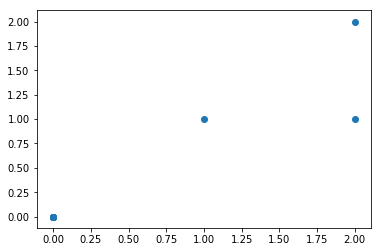

In [73]:
plt.scatter(uranium_pos[:,0], uranium_pos[:,1]);

In [13]:
t0 = time()
# fig, ax = plt.subplots()
# fig.set_size_inches(6, 6)
fig = plt.figure(figsize=(6, 6))
# box_size = 
ax = fig.add_axes([0, 0, 1, 1], frameon=True)
ax.set_xlim(0, 1), ax.set_xticks([])
ax.set_ylim(0, 1), ax.set_yticks([])

num_discs = 100
disc_size = 160
vmax = 0#1e-3
discs = np.zeros(num_discs, dtype=[('position', float, 2),
                                   ('velocity', float, 2),
                                   ('color',    float, 4)])

np.random.seed(123)
discs['position'] = #np.random.uniform(0, 1, (num_discs, 2))
discs['velocity'] = np.random.uniform(-vmax, vmax, (num_discs, 2))
discs['color']    = np.repeat([[0,1,0,1]], repeats=num_discs, axis=0)

scat = ax.scatter(discs['position'][:, 0], discs['position'][:, 1],
                  s=disc_size, lw=0.5, edgecolors='k',
                  facecolors=discs['color'])
# disc 0
# discs['position'][0] = np.array([.5, 0.5])
discs['velocity'][0] = np.array([5*vmax, 5*vmax*1.1])
discs['color'][0] = [1,0,0,1]

dt = 0
def animate(frame, dt=dt):
    dt += 1
    x, v = move(discs['position'], discs['velocity'], dt, box_size=1)
    discs['position'], discs['velocity'] = x, v
    # 
    for idx in range(1, num_discs):
        if distance(discs['position'][0], discs['position'][idx]) < 0.0002:
            discs['color'][idx] = [1,0,0,1]
    # Update the scatter collection, with the new colors, sizes and positions.
    scat.set_facecolors(discs['color'])
    scat.set_offsets(discs['position'])
    return dt

num_loops = 1
animt = FuncAnimation(fig, animate, frames=100*num_loops, interval=30, repeat=True)
video = animt.to_html5_video()
html  = display.HTML(video)
display.display(html)
plt.close()
runtime(t0)

2 sec.


In [9]:
"""
Animation of Elastic collisions with Gravity

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
Please feel free to use and modify this, but keep the above information. Thanks!
"""

from scipy.spatial.distance import pdist, squareform
import scipy.integrate as integrate

t0 = time()

class ParticleBox:
    """Orbits class
    
    init_state is an [N x 4] array, where N is the number of particles:
       [[x1, y1, vx1, vy1],
        [x2, y2, vx2, vy2],
        ...               ]

    bounds is the size of the box: [xmin, xmax, ymin, ymax]
    """
    def __init__(self,
                 init_state = [[1, 0, 0, -1],
                               [-0.5, 0.5, 0.5, 0.5],
                               [-0.5, -0.5, -0.5, 0.5]],
                 bounds = [-2, 2, -2, 2],
                 size = 0.04,
                 M = 0.05,
                 G = 0):
        self.init_state = np.asarray(init_state, dtype=float)
        self.M = M * np.ones(self.init_state.shape[0])
        self.size = size
        self.state = self.init_state.copy()
        self.time_elapsed = 0
        self.bounds = bounds
        self.G = G

    def step(self, dt):
        """step once by dt seconds"""
        self.time_elapsed += dt
        
        # update positions
        self.state[:, :2] += dt * self.state[:, 2:]

        # find pairs of particles undergoing a collision
        D = squareform(pdist(self.state[:, :2]))
        ind1, ind2 = np.where(D < 2 * self.size)
        unique = (ind1 < ind2)
        ind1 = ind1[unique]
        ind2 = ind2[unique]

        # update velocities of colliding pairs
        for i1, i2 in zip(ind1, ind2):
            # mass
            m1 = self.M[i1]
            m2 = self.M[i2]

            # location vector
            r1 = self.state[i1, :2]
            r2 = self.state[i2, :2]

            # velocity vector
            v1 = self.state[i1, 2:]
            v2 = self.state[i2, 2:]

            # relative location & velocity vectors
            r_rel = r1 - r2
            v_rel = v1 - v2

            # momentum vector of the center of mass
            v_cm = (m1 * v1 + m2 * v2) / (m1 + m2)

            # collisions of spheres reflect v_rel over r_rel
            rr_rel = np.dot(r_rel, r_rel)
            vr_rel = np.dot(v_rel, r_rel)
            v_rel = 2 * r_rel * vr_rel / rr_rel - v_rel

            # assign new velocities
            self.state[i1, 2:] = v_cm + v_rel * m2 / (m1 + m2)
            self.state[i2, 2:] = v_cm - v_rel * m1 / (m1 + m2) 

        # check for crossing boundary
        crossed_x1 = (self.state[:, 0] < self.bounds[0] + self.size)
        crossed_x2 = (self.state[:, 0] > self.bounds[1] - self.size)
        crossed_y1 = (self.state[:, 1] < self.bounds[2] + self.size)
        crossed_y2 = (self.state[:, 1] > self.bounds[3] - self.size)

        self.state[crossed_x1, 0] = self.bounds[0] + self.size
        self.state[crossed_x2, 0] = self.bounds[1] - self.size

        self.state[crossed_y1, 1] = self.bounds[2] + self.size
        self.state[crossed_y2, 1] = self.bounds[3] - self.size

        self.state[crossed_x1 | crossed_x2, 2] *= -1
        self.state[crossed_y1 | crossed_y2, 3] *= -1

        # add gravity
        self.state[:, 3] -= self.M * self.G * dt


#------------------------------------------------------------
# set up initial state
np.random.seed(0)
init_state = 0 + np.random.random((10, 4))
init_state[:, :2] *= 3.9

box = ParticleBox(init_state, size=0.04)
dt = 1. / 50 # fps


#------------------------------------------------------------
# set up figure and animation
fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(-3.2, 3.2), ylim=(-2.4, 2.4))

# particles holds the locations of the particles
particles, = ax.plot([], [], 'bo', ms=6)

# rect is the box edge
rect = plt.Rectangle(box.bounds[::2],
                     box.bounds[1] - box.bounds[0],
                     box.bounds[3] - box.bounds[2],
                     ec='none', lw=2, fc='none')
ax.add_patch(rect)

def init():
    """initialize animation"""
    global box, rect
    particles.set_data([], [])
    rect.set_edgecolor('none')
    return particles, rect

def animate(i):
    """perform animation step"""
    global box, rect, dt, ax, fig
    box.step(dt)

    ms = int(fig.dpi * 2 * box.size * fig.get_figwidth()
             / np.diff(ax.get_xbound())[0])
    
    # update pieces of the animation
    rect.set_edgecolor('k')
    particles.set_data(box.state[:, 0], box.state[:, 1])
    particles.set_markersize(ms)
    return particles, rect

animt = FuncAnimation(fig, animate, frames=600,
                      interval=10, blit=True, init_func=init)

# animt = FuncAnimation(fig, animate, init_func=init, frames=100*num_loops, interval=30, repeat=True)
video = animt.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()
runtime(t0)

22 sec.


In [6]:
animt.save('animt2.gif', writer='imagemagick')